In [1]:
!pip install torch
!pip install tensorflow


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
#load data frame
df = pd.read_csv("/ratings.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [9]:
df.userId.nunique()

610

In [10]:
df.movieId.nunique()

9724

In [11]:
df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [12]:
df.shape

(100836, 4)

In [13]:
#creating dataset and defining methods
class MovieDataset:
    def __init__(self, users, movies,ratings):
        self.users= users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        users = self.users[item]
        movies=self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long)
        }

In [22]:
#defining class for converting features in embeddings
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)

        self.out = nn.Linear(64,1)

    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)

        output = self.out(output)
        return output


In [16]:
#defining labels and test/train datasets
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train , df_valid = model_selection.train_test_split(df, test_size =0.1, random_state=42,stratify=df.rating.values)

train_dataset = MovieDataset(
    users = df_train.userId.values,
    movies = df_train.movieId.values,
    ratings= df_train.rating.values
)

valid_dataset = MovieDataset(
    users = df_valid.userId.values,
    movies = df_valid.movieId.values,
    ratings= df_valid.rating.values
)

In [20]:
#creating dataloaders
train_loader = DataLoader(dataset =train_dataset, batch_size =4, shuffle =True, num_workers=2)
validation_loader =DataLoader(dataset= valid_dataset, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(train_loader)
dataloader_data = next(dataiter)
print(dataloader_data)

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a53e643bc70>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a53e643bc70>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    : if w.is_alive():can only test a child process

  File "/usr/lib/

{'users': tensor([ 41, 598, 236, 413]), 'movies': tensor([  92, 7481, 1056, 5692]), 'ratings': tensor([4, 2, 3, 3])}


In [58]:
#definng model
model = RecSysModel(n_users = len(lbl_user.classes_),
                    n_movies= len(lbl_movie.classes_),

                    ).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr = 0.0009, weight_decay=1e-5)
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
loss_func = nn.MSELoss()

In [59]:
#train model
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000,5000
step_cnt =0
all_losses_list = []

model.train()
for epoch_i in range(epochs):
  for i, train_data in enumerate(train_loader):
    output = model(train_data['users'],
                   train_data['movies']
                   )
    rating = train_data['ratings'].view(4,-1).to(torch.float32)

    loss = loss_func(output, rating)
    total_loss += loss.sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    step_cnt += len(train_data["users"])
    if(step_cnt % plot_steps ==0):
      avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
      print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
      all_losses_list.append(avg_loss)
      total_loss =0

epoch 0 loss at step: 5000 is 0.5306861910507082
epoch 0 loss at step: 10000 is 0.19911823820732533
epoch 0 loss at step: 15000 is 0.11218492562687024
epoch 0 loss at step: 20000 is 0.08551193343736231
epoch 0 loss at step: 25000 is 0.07574056631764398
epoch 0 loss at step: 30000 is 0.06911915025115013
epoch 0 loss at step: 35000 is 0.06237006527720951
epoch 0 loss at step: 40000 is 0.06167934398090001
epoch 0 loss at step: 45000 is 0.06011168856851291
epoch 0 loss at step: 50000 is 0.0595060354127083
epoch 0 loss at step: 55000 is 0.05685980175491422
epoch 0 loss at step: 60000 is 0.05710535855386406
epoch 0 loss at step: 65000 is 0.05673832270968705
epoch 0 loss at step: 70000 is 0.05621315527055413
epoch 0 loss at step: 75000 is 0.05755251100612804
epoch 0 loss at step: 80000 is 0.05591749873096123
epoch 0 loss at step: 85000 is 0.052988092816760764
epoch 0 loss at step: 90000 is 0.05391264692619443


<function matplotlib.pyplot.show(close=None, block=None)>

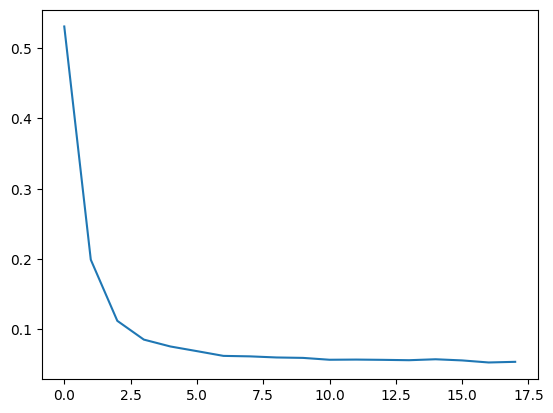

In [60]:
#plot loss curve
plt.figure()
plt.plot(all_losses_list)
plt.show

In [64]:
#evaluate model
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []
model.eval()
with torch.no_grad():
  for i,batched_data in enumerate(validation_loader):
    model_output = model(batched_data['users'],
                   batched_data['movies']
                   )
    model_output_list.append(model_output.sum().item() / len(batched_data['users']))
    target_rating = batched_data["ratings"]
    target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

    print(f"model output: {model_output}")
    print(f"target rating: {target_rating}")

rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

Streaming output truncated to the last 5000 lines.
        [3.7795],
        [2.7987],
        [3.9178]])
target rating: tensor([4, 4, 2, 5])
model output: tensor([[3.9949],
        [3.3585],
        [3.8176],
        [2.5100]])
target rating: tensor([5, 3, 4, 4])
model output: tensor([[2.7565],
        [2.5012],
        [3.3402],
        [3.3026]])
target rating: tensor([3, 3, 5, 3])
model output: tensor([[2.7620],
        [3.7801],
        [3.1555],
        [3.5588]])
target rating: tensor([1, 4, 2, 3])
model output: tensor([[3.1608],
        [3.8656],
        [3.7083],
        [3.2470]])
target rating: tensor([3, 4, 4, 5])
model output: tensor([[3.5092],
        [2.0570],
        [3.7487],
        [3.3855]])
target rating: tensor([5, 1, 5, 2])
model output: tensor([[3.5788],
        [2.0551],
        [3.7005],
        [3.0867]])
target rating: tensor([5, 2, 3, 3])
model output: tensor([[3.5532],
        [3.5758],
        [2.0667],
        [3.7360]])
target rating: tensor([3, 3, 2, 4

In [65]:
#evaluate using precision and recall
from collections import defaultdict
user_est_true = defaultdict(list)

with torch.no_grad():
  for i, batched_data in enumerate(validation_loader):
    users = batched_data['users']
    movies = batched_data['movies']
    ratings = batched_data['ratings']

    model_output = model(batched_data['users'], batched_data['movies'])

    for i in range(len(users)):
      user_id = users[i].item()
      movie_id = movies[i].item()
      pred_rating = model_output[i][0].item()
      true_rating = ratings[i].item()

      print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
      user_est_true[user_id].append((pred_rating, true_rating))



Streaming output truncated to the last 5000 lines.
202, 257, 4.379171848297119, 5
67, 1492, 2.5851387977600098, 3
91, 773, 3.4079020023345947, 4
49, 5682, 3.2227697372436523, 3
231, 2941, 3.6008639335632324, 4
245, 5959, 3.6746408939361572, 3
427, 4153, 2.7415835857391357, 3
214, 1575, 3.9232687950134277, 4
599, 1720, 2.9862091541290283, 4
216, 550, 2.5909485816955566, 2
95, 659, 4.43715763092041, 4
169, 175, 3.1487483978271484, 3
5, 196, 3.382706642150879, 5
15, 2144, 3.3981688022613525, 3
176, 697, 3.2935073375701904, 5
605, 835, 3.555802583694458, 3
197, 3105, 3.3855810165405273, 4
317, 1242, 3.869346857070923, 4
72, 6203, 3.6724462509155273, 4
67, 1548, 2.867081880569458, 3
479, 5589, 3.01009464263916, 4
597, 898, 3.9057469367980957, 2
27, 819, 2.868899345397949, 3
181, 888, 3.3796091079711914, 4
67, 1607, 3.031691074371338, 2
446, 253, 3.5264997482299805, 3
605, 6596, 3.881073474884033, 3
536, 4131, 4.081062316894531, 4
110, 4900, 3.5729222297668457, 3
297, 7061, 2.771442174911499

In [68]:
with torch.no_grad():
  precesions = dict()
  recalls = dict()

  k =10
  threshold = 3.5
  for uid, user_ratings in user_est_true.items():
    user_ratings.sort(key= lambda x : x[0], reverse = True)
    n_rel = sum ((true_r>=threshold) for (_, true_r)in user_ratings)

    n_rec_k = sum((est>= threshold) for (est,_)in user_ratings[:k])

    n_rel_and_rec_k = sum(((true_r>=threshold) and (est>=threshold))
                          for (est, true_r) in user_ratings[:k])

    print(f"uid {uid}, n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

    precesions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k !=0 else 0
    recalls[uid] = n_rel_and_rec_k / n_rel if n_rel !=0 else 0


uid 308, n_rel 10, n_rec_k 8, n_rel_and_rec_k 6
uid 478, n_rel 8, n_rec_k 7, n_rel_and_rec_k 5
uid 605, n_rel 65, n_rec_k 10, n_rel_and_rec_k 5
uid 317, n_rel 38, n_rec_k 10, n_rel_and_rec_k 6
uid 125, n_rel 2, n_rec_k 0, n_rel_and_rec_k 0
uid 264, n_rel 6, n_rec_k 4, n_rel_and_rec_k 3
uid 227, n_rel 2, n_rec_k 1, n_rel_and_rec_k 1
uid 413, n_rel 121, n_rec_k 10, n_rel_and_rec_k 9
uid 316, n_rel 14, n_rec_k 10, n_rel_and_rec_k 8
uid 407, n_rel 11, n_rec_k 10, n_rel_and_rec_k 8
uid 201, n_rel 36, n_rec_k 10, n_rel_and_rec_k 10
uid 488, n_rel 14, n_rec_k 0, n_rel_and_rec_k 0
uid 338, n_rel 22, n_rec_k 10, n_rel_and_rec_k 8
uid 65, n_rel 23, n_rec_k 10, n_rel_and_rec_k 7
uid 502, n_rel 1, n_rec_k 2, n_rel_and_rec_k 0
uid 533, n_rel 19, n_rec_k 10, n_rel_and_rec_k 8
uid 41, n_rel 26, n_rec_k 10, n_rel_and_rec_k 9
uid 386, n_rel 31, n_rec_k 5, n_rel_and_rec_k 5
uid 598, n_rel 22, n_rec_k 0, n_rel_and_rec_k 0
uid 383, n_rel 2, n_rec_k 0, n_rel_and_rec_k 0
uid 273, n_rel 28, n_rec_k 10, n_rel

In [69]:
print(f"precsion @ {k}: {sum(prec for prec in precesions.values())/len(precesions)}")
print(f"recall @ {k}: {sum(rec for rec in recalls.values())/len(recalls)}")

precsion @ 10: 0.5871177248677252
recall @ 10: 0.47103610875371954
